# SLDA desde python: depuración de texto, modelamiento y evaluación
## Profesor: Nicolás López

# Dependencias

In [44]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import tomotopy as tp
import spacy
import re
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [ ]:
# Descargar el modelo de español: python -m spacy download es_core_news_sm
! python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 33.0 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


# Texto genérico y variable respuesta

In [2]:
paragraphs1 = [
    # Positivos (1-12)
    # Trabajo
    {"text": "Trabajar en equipo trae grandes resultados. Compartir ideas con colegas mejora los proyectos. Un buen ambiente laboral motiva a todos. Celebrar logros pequeños aumenta la productividad. El apoyo mutuo hace el trabajo más ligero.", "response": 1, "topic": "trabajo"},
    {"text": "Aprender nuevas habilidades en el trabajo es gratificante. Los desafíos profesionales ayudan a crecer. Recibir retroalimentación positiva anima a seguir mejorando. Colaborar con compañeros talentosos inspira creatividad. El progreso diario construye una carrera sólida.", "response": 1, "topic": "trabajo"},
    {"text": "Un jefe comprensivo marca la diferencia. Horarios flexibles permiten equilibrar vida y trabajo. Charlas motivacionales refuerzan el propósito del equipo. Las metas claras guían el esfuerzo diario. Valorar el trabajo bien hecho genera satisfacción.", "response": 1, "topic": "trabajo"},
    {"text": "Practicar deportes en equipo enseña cooperación. Cada entrenamiento fortalece cuerpo y mente. Las victorias se disfrutan más juntos. Superar desafíos diarios da confianza. El ejercicio regular mantiene salud física y mental.", "response": 1, "topic": "deportes"},
    {"text": "Correr al aire libre libera estrés. Competir sanamente fija metas personales. Amigos deportistas comparten consejos útiles. Ganar o perder, siempre se aprende. La disciplina deportiva forma carácter.", "response": 1, "topic": "deportes"},
    {"text": "El fútbol une a comunidades enteras. Niños aprenden valores jugando en equipos. Medallas representan horas de dedicación. El sudor después del ejercicio da orgullo. Los deportes crean historias inolvidables.", "response": 1, "topic": "deportes"},
    {"text": "Tocar un instrumento relaja el alma. Las melodías alegres animan cualquier día. Conciertos en vivo llenan de energía. Cantar con amigos crea conexiones únicas. La música cura emociones y une culturas.", "response": 1, "topic": "música"},
    {"text": "Aprender letras de canciones mejora la memoria. Bailar al ritmo favorito libera endorfinas. Componer versos propios es terapia creativa. Los festivales musicales son experiencias vibrantes. La música acompaña momentos felices.", "response": 1, "topic": "música"},
    {"text": "Viajar amplía la visión del mundo. Probar comidas típicas descubre sabores nuevos. Conocer monumentos históricos enseña sobre culturas. Fotografiar paisajes guarda recuerdos para siempre. Cada viaje es una aventura única.", "response": 1, "topic": "viajes"},
    {"text": "Planear rutas emociona antes de partir. Maletas llenas de esperanza e ilusión. Hoteles acogedores hacen sentir como en casa. Conversar con locales enriquece la experiencia. Los viajes renuevan la energía vital.", "response": 1, "topic": "viajes"},
    {"text": "Tener mascotas reduce la sensación de soledad. Perros leales siempre esperan con cariño. Gatos independientes dan compañía tranquila. Aprender a cuidar animales enseña responsabilidad. Su amor incondicional mejora el ánimo.", "response": 1, "topic": "animales"},
    {"text": "Ver pájaros volar libremente es hermoso. Rescatar animales abandonados cambia vidas. Zoológicos bien gestionados educan a niños. Proteger especies en peligro salva ecosistemas. Los animales merecen respeto y cuidado.", "response": 1, "topic": "animales"},

    # Negativos (13-20)
    {"text": "El exceso de trabajo causa agotamiento. Plazos ajustados generan estrés constante. Conflictos con colegas dañan el ambiente. Falta de reconocimiento desmotiva a cualquiera. Equilibrar vida personal y laboral es difícil.", "response": 0, "topic": "trabajo"},
    {"text": "Jefes autoritarios crean miedo en la oficina. Reuniones interminables sin decisiones concretas. Salarios bajos para horas extras no pagadas. Promesas incumplidas de ascensos frustran a todos. El burnout laboral es una realidad dura.", "response": 0, "topic": "trabajo"},
    {"text": "Lesiones deportivas pueden terminar carreras. Presión por ganar quita la diversión. Entrenar bajo lluvia o frío extremo agota. Compararse con otros atletas genera inseguridad. El deporte de alto nivel desgasta física y mentalmente.", "response": 0, "topic": "deportes"},
    {"text": "Equipos tóxicos arruinan la experiencia deportiva. Criticas duras por errores en partidos. Falta de recursos para entrenar adecuadamente. Competir con lesiones por obligación empeora la salud. A veces el deporte se vuelve sufrimiento.", "response": 0, "topic": "deportes"},
    {"text": "Vecinos molestos por ensayos musicales fuertes. Oír la misma canción repetida irrita. Conciertos cancelados por mal tiempo decepcionan. Artistas que pierden pasión por fama. La industria a veces explota talentos nuevos.", "response": 0, "topic": "música"},
    {"text": "Vuelos cancelados arruinan planes de viaje. Extraviar maletas en aeropuertos causa caos. Turistas irrespetuosos dañan sitios históricos. Presupuestos ajustados limitan experiencias. A veces viajar es más estresante que relajante.", "response": 0, "topic": "viajes"},
    {"text": "Animales abandonados sufren en las calles. Dueños irresponsables no vacunan a sus mascotas. Caza ilegal de especies protegidas indigna. Zoológicos en mal estado maltratan animales. El ego humano destruye hábitats naturales.", "response": 0, "topic": "animales"},
    {"text": "Perros agresivos por entrenamiento inadecuado. Gatos callejeros multiplicándose sin control. Testear productos en animales es cruel. Contaminación que envenena ríos y peces. Falta de conciencia sobre protección animal duele.", "response": 0, "topic": "animales"}
]

paragraphs2 = [
    # Positivos (1-12)
    {"text": "Un trabajo estable brinda seguridad económica. Compañeros colaborativos hacen las tareas más sencillas. Lograr metas profesionales da gran satisfacción. Los reconocimientos públicos motivan a seguir mejorando. Un empleo significativo da propósito a la vida diaria.", "response": 1, "topic": "trabajo"},
    {"text": "Trabajar desde casa ahorra tiempo de transporte. Proyectos innovadores despiertan la creatividad laboral. Capacitaciones constantes mantienen habilidades actualizadas. Un jefe que escucha mejora el ambiente de equipo. El equilibrio entre vida y trabajo aumenta la felicidad.", "response": 1, "topic": "trabajo"},
    {"text": "Ofrecer ayuda a nuevos empleados fortalece el grupo. Salarios justos reflejan valoración profesional. Charlas informales en la oficina crean amistades. Ver crecer la empresa da orgullo colectivo. El trabajo bien hecho siempre deja huella.", "response": 1, "topic": "trabajo"},
    {"text": "Nadar en la mañana activa todo el cuerpo. Ganar una carrera local llena de orgullo. El tenis enseña a pensar rápido bajo presión. Meditar después del ejercicio calma la mente. Los deportes acuáticos refrescan en días calurosos.", "response": 1, "topic": "deportes"},
    {"text": "El ciclismo en grupo fomenta la amistad. Aplaudir a compañeros mejora el espíritu de equipo. Superar marcas personales da confianza extrema. Usar ropa deportiva cómoda optimiza el rendimiento. El deporte nocturno bajo las estrellas relaja.", "response": 1, "topic": "deportes"},
    {"text": "Enseñar deportes a niños desarrolla su coordinación. Trofeos brillantes simbolizan horas de dedicación. Hidratarse bien durante el entrenamiento es vital. Los ejercicios de estiramiento previenen lesiones. El deporte une generaciones en familia.", "response": 1, "topic": "deportes"},
    {"text": "Las canciones infantiles alegran los días grises. Tocar batería libera energía acumulada. Descubrir artistas nuevos amplía gustos musicales. Letras positivas elevan el estado de ánimo. La música en vivo crea momentos mágicos.", "response": 1, "topic": "música"},
    {"text": "Aprender guitarra con amigos es divertido. Las bandas sonoras hacen películas inolvidables. Cantar en la ducha relaja después del trabajo. Los coros comunitarios unen voces y corazones. La música folklórica preserva tradiciones culturales.", "response": 1, "topic": "música"},
    {"text": "Viajar en tren permite admirar paisajes lentamente. Conocer museos locales enseña historia práctica. Hacer amigos durante un viaje enriquece la experiencia. Fotografiar atardeceres en nuevos lugares inspira. Cada viaje enseña algo sobre uno mismo.", "response": 1, "topic": "viajes"},
    {"text": "Probar postres típicos es lo mejor de viajar. Hoteles con vistas al mar relajan profundamente. Viajar con un presupuesto ajustado fomenta la creatividad. Regresar a casa con souvenirs trae recuerdos felices.", "response": 1, "topic": "viajes"},
    {"text": "Adoptar perros callejeros cambia dos vidas. Observar delfines en libertad es emocionante. Caballos que ayudan en terapias son héroes. Alimentar pájaros en el jardín atrae biodiversidad. Los animales de granja requieren cuidados responsables.", "response": 1, "topic": "animales"},
    {"text": "Voluntariados en refugios salvan animales necesitados. Los gatos ronroneando curan el estrés diario. Documentales sobre vida salvaje enseñan respeto. Colocar nidos artificiales protege aves urbanas. El amor animal no entiende de especies.", "response": 1, "topic": "animales"},

    # Negativos (13-20)
    {"text": "Jornadas laborales de 12 horas agotan física y mentalmente. Discriminación por edad en algunas empresas. Robo de ideas sin dar crédito al creador. Máquinas reemplazando puestos humanos. Trabajar enfermo por miedo a despidos.", "response": 0, "topic": "trabajo"},
    {"text": "Ascensos dados por favoritismo, no méritos. Oficinas sin ventilación adecuada en verano. Cobrar menos que compañeros por mismo rol. Acoso laboral silenciado por miedo. Contratos temporales sin estabilidad real.", "response": 0, "topic": "trabajo"},
    {"text": "Dopaje en competencias arruina la justicia. Padres exigiendo demasiado a hijos atletas. Lesiones cerebrales por deportes extremos. Competencias canceladas por corrupción. Presión para usar equipo costoso e inaccesible.", "response": 0, "topic": "deportes"},
    {"text": "Discriminación a mujeres en ligas deportivas. Instalaciones públicas en mal estado. Deportistas retirados sin pensiones dignas. Agresiones entre fanáticos en estadios. El deporte infantil convertido en negocio.", "response": 0, "topic": "deportes"},
    {"text": "Artistas obligados a cambiar su estilo. Piratería musical afectando ingresos. Altavoces rotos en conciertos importantes. Músicos callejeros siendo multados. Canciones románticas que normalizan el control.", "response": 0, "topic": "música"},
    {"text": "Reservas de hoteles perdidas por errores web. Turistas intoxicados por comida callejera. Aeropuertos cobrando tarifas abusivas. Pérdida de documentos en países extranjeros. Viajes familiares arruinados por mal clima.", "response": 0, "topic": "viajes"},
    {"text": "Perros encadenados toda su vida. Acuarios sobrepoblados estresando peces. Circos usando animales como esclavos. Muerte de koalas por incendios forestales. Tráfico ilegal de aves exóticas.", "response": 0, "topic": "animales"},
    {"text": "Dueños dejando gatos en carreteras. Experimentos con cosméticos en conejos. Contaminación plástica matando tortugas. Zoológicos dando comida no adecuada. Falta de leyes para proteger animales.", "response": 0, "topic": "animales"}
]

paragraphs3 = [
    # Positivos (1-12)
    {"text": "Trabajar con horarios flexibles mejora la concentración. Compartir logros con el equipo genera orgullo colectivo. Las empresas que ofrecen formación continua retienen talento. Un café con compañeros alivia el estrés laboral. Sentirse valorado en el trabajo aumenta la lealtad hacia la empresa.", "response": 1, "topic": "trabajo"},
    {"text": "Los proyectos internacionales amplían perspectivas profesionales. Mentorías entre empleados nuevos y expertos aceleran el aprendizaje. Oficinas luminosas con plantas mejoran el ánimo diario. Celebrar cumpleaños en el trabajo fortalece lazos humanos. Un salario justo motiva a dar lo mejor cada día.", "response": 1, "topic": "trabajo"},
    {"text": "Trabajar desde lugares remotos acerca oportunidades globales. Jornadas laborales con descansos frecuentes aumentan productividad. Reconocer errores y aprender de ellos crea ambientes honestos. Equipos diversos aportan soluciones creativas. El trabajo estable permite planificar un futuro tranquilo.", "response": 1, "topic": "trabajo"},
    {"text": "El baloncesto enseña estrategia y rapidez mental. Nadar en el mar fortalece músculos con resistencia natural. Meditar después del yoga profundiza la relajación. Clubes deportivos para adultos mayores promueven vida activa. Ganar un torneo local llena de orgullo al pueblo.", "response": 1, "topic": "deportes"},
    {"text": "El senderismo en montañas conecta con la naturaleza. Entrenar con amigos hace el ejercicio más divertido. Niños en escuelas deportivas desarrollan disciplina temprana. Trofeos simbolizan esfuerzo y perseverancia. Los deportes al aire libre oxigenan el cerebro.", "response": 1, "topic": "deportes"},
    {"text": "El ciclismo urbano reduce el estrés del tráfico. Estiramientos matutinos preparan el cuerpo para el día. Ligas comunitarias unen vecinos de todas las edades. Aprender a perder enseña humildad y resiliencia. El deporte es medicina preventiva para la salud.", "response": 1, "topic": "deportes"},
    {"text": "La música clásica mejora la concentración al estudiar. Tocar piano en familia crea recuerdos inolvidables. Festivales de jazz atraen turistas de todo el mundo. Las canciones tradicionales preservan historias ancestrales. Bailar salsa libera endorfinas y alegra el corazón.", "response": 1, "topic": "música"},
    {"text": "Aprender a leer partituras es como un nuevo idioma. Coros infantiles enseñan armonía y trabajo en equipo. Músicos callejeros alegran las plazas con su arte. Playlists motivadoras para hacer ejercicio con energía. La música une a personas de distintas generaciones.", "response": 1, "topic": "música"},
    {"text": "Viajar en autocaravana da libertad para explorar. Alojarse en pueblos pequeños descubre autenticidad cultural. Fotografiar auroras boreales es un sueño cumplido. Aprender frases básicas en otro idioma abre sonrisas. Los viajes en solitario enseñan autoconfianza y valentía.", "response": 1, "topic": "viajes"},
    {"text": "Probar especias exóticas en mercados locales. Trekking por selvas con guías expertos en biodiversidad. Dormir en cabañas ecológicas reduce huella ambiental. Viajar sin itinerario fijo permite sorpresas maravillosas. Conocer otras costumbres amplía la tolerancia cultural.", "response": 1, "topic": "viajes"},
    {"text": "Los perros de terapia ayudan en hospitales y escuelas. Observar ballenas en su hábitat natural es conmovedor. Refugios que rehabilitan animales heridos dan esperanza. Colibríes polinizando flores son clave para ecosistemas. Adoptar animales ancianos brinda amor en sus últimos años.", "response": 1, "topic": "animales"},
    {"text": "Proyectos de reforestación protegen hogares de animales. Veterinarios voluntarios en zonas rurales salvan vidas. Documentar especies en peligro crea conciencia global. Los caballos enseñan paciencia y conexión emocional. El respeto a los animales refleja humanidad.", "response": 1, "topic": "animales"},

    # Negativos (13-20)
    {"text": "Jefes que exigen respuestas a altas horas de la noche. Competitividad tóxica entre colegas por ascensos. Máquinas reemplazando puestos manuales sin alternativas. Trabajadores temporales sin acceso a beneficios de salud. Empresas que ignoran el acoso laboral para evitar escándalos.", "response": 0, "topic": "trabajo"},
    {"text": "Reuniones virtuales interminables sin avances reales. Salarios congelados por años a pesar de la inflación. Empleados quemados tomando pastillas para seguir rindiendo. Discriminación hacia madres que piden horarios reducidos. Contratos que obligan a trabajar días festivos.", "response": 0, "topic": "trabajo"},
    {"text": "Atletas obligados a competir lesionados por patrocinadores. Padres agresivos gritando insultos en partidos infantiles. Estrellas deportivas explotadas por marcas comerciales. Gimnasios públicos con máquinas rotas y sin mantenimiento. Deportistas retirados luchando contra depresión y olvido.", "response": 0, "topic": "deportes"},
    {"text": "Árbitros corruptos manipulando resultados de ligas. Falta de apoyo económico para deportistas paralímpicos. Lesiones cerebrales ignoradas en deportes de contacto. Clubes elitistas que excluyen a personas de bajos recursos. El deporte convertido en negocio pierde su esencia.", "response": 0, "topic": "deportes"},
    {"text": "Artistas independientes sin acceso a estudios profesionales. Plataformas digitales pagando centavos por reproducciones. Canciones con letras violentas normalizando el odio. Músicos con pérdida auditiva por volumen excesivo. Industria que exige imagen perfecta sobre talento real.", "response": 0, "topic": "música"},
    {"text": "Turistas que tallan nombres en monumentos históricos. Aerolíneas perdiendo equipajes frecuentemente sin compensar. Alquileres vacacionales encareciendo viviendas locales. Guías turísticos dando información falsa por comisiones. Viajes de negocios que roban tiempo familiar valioso.", "response": 0, "topic": "viajes"},
    {"text": "Animales de circo drogados para obedecer órdenes. Perros de raza criados en condiciones inhumanas. Cazadores furtivos matando elefantes por marfil. Acuarios usando químicos dañinos para mantener limpieza. Mascotas exóticas abandonadas en ecosistemas no aptos.", "response": 0, "topic": "animales"},
    {"text": "Granjas industriales hacinando animales sin ventilación. Experimentos con cachorros para testear productos. Contaminación por plástico asfixiando a tortugas marinas. Dueños dejando perros en coches bajo sol extremo. Tráfico de especies destruyendo biodiversidad.", "response": 0, "topic": "animales"}
]

paragraphs4 = [
    # Positivos (1-12)
    {"text": "Nuestro equipo de trabajo logró terminar el proyecto difícil gracias a la comunicación constante. El jefe organizó reuniones cortas para resolver dudas y todos compartieron ideas. Al final, celebramos con una cena grupal. La confianza y el respeto hicieron que este reto fuera una experiencia de crecimiento.", "response": 1, "topic": "trabajo"},
    {"text": "El deporte cambió mi vida: empecé a correr cada mañana para liberar estrés y conocí a un grupo en el parque. Ahora entrenamos juntos para carreras locales. La energía del equipo me motiva, y mi salud ha mejorado notablemente desde que comenzamos.", "response": 1, "topic": "deportes"},
    {"text": "Viajar a un pueblo costero me enseñó la importancia de las tradiciones. Los pescadores nos contaron historias antiguas mientras compartíamos su comida típica. Las playas tranquilas y el ritmo lento de vida me hicieron valorar la simplicidad de las cosas bien hechas.", "response": 1, "topic": "viajes"},
    {"text": "Adoptamos un perro rescatado de la calle, y su transformación fue increíble. Con paciencia y visitas al veterinario, aprendió a confiar. Ahora acompaña a los niños en sus tareas y llena la casa de alegría con sus travesuras diarias.", "response": 1, "topic": "animales"},
    {"text": "En la oficina, implementamos viernes musicales: cada semana alguien elige una playlist. Esto rompió la rutina y descubrimos nuevos géneros. La música relajante de la tarde ayuda a concentrarnos, y los debates sobre canciones crearon amistades entre departamentos.", "response": 1, "topic": "música"},
    {"text": "Mi primer triatlón fue un desafío físico y mental. Durante meses, entrené natación al amanecer y ciclismo en colinas. El día de la carrera, el apoyo del público me dio fuerzas. Cruzar la meta me enseñó que los límites están en la mente.", "response": 1, "topic": "deportes"},
    {"text": "Como guía turístico, he visto cómo los viajeros se emocionan al entender nuestra historia. Una familia japonesa lloró al entrar en la catedral; les recordó a sus templos. Esos momentos confirman que viajar es conectar almas, no solo visitar lugares.", "response": 1, "topic": "viajes"},
    {"text": "En el refugio de animales, rehabilitamos un águila herida. Cuando finalmente voló libre, los voluntarios nos abrazamos en silencio. Trabajar aquí me muestra que cada criatura merece una segunda oportunidad, sin importar cuán pequeña o salvaje parezca.", "response": 1, "topic": "animales"},
    {"text": "Aprendí a tocar el violín con videos online durante la pandemia. Al principio, sonaba terrible, pero practiqué cada noche. Ahora toco en un grupo amateur; nuestro primer concierto en el parque atrajo a vecinos sonrientes. La música unió al barrio en tiempos difíciles.", "response": 1, "topic": "música"},
    {"text": "Mi empresa permite trabajar desde cualquier país dos meses al año. Elegí Grecia: por las mañanas termino tareas rápido para explorar playas al atardecer. Esta flexibilidad me hace más productivo y renovado. Equilibrar responsabilidad y aventura es posible con buena organización.", "response": 1, "topic": "trabajo"},
    {"text": "El equipo de baloncesto escolar perdió la final, pero los padres organizamos una fiesta sorpresa. Los niños rieron con juegos y recibieron medallas simbólicas. Aprendieron que el esfuerzo vale más que un trofeo, y ahora entrenan con más pasión que nunca.", "response": 1, "topic": "deportes"},
    {"text": "Un viaje en tren por los Alpes fue mágico: ventanas llenas de montañas nevadas y pueblos de cuento. Conocí a una anciana que tejía bufandas; me regaló una mientras me contaba de su juventud. Esos detalles hacen que el mundo se sienta cálido y cercano.", "response": 1, "topic": "viajes"},

    # Negativos (13-20)
    {"text": "En mi trabajo anterior, el jefe gritaba por errores mínimos. Colegas competían por humillar a otros en reuniones. Renuncié cuando vi llorar a una practicante en el baño. Nadie merece ese ambiente tóxico; ahora valoro más mi paz mental que un sueldo alto.", "response": 0, "topic": "trabajo"},
    {"text": "El fútbol profesional destruyó la rodilla de mi hermano. Los entrenadores lo obligaron a jugar lesionado para no perder patrocinios. Ahora, a sus 28 años, necesita cirugías constantes y su depresión empeora cada día. El deporte que amaba lo dejó sin futuro.", "response": 0, "topic": "deportes"},
    {"text": "Compré entradas para mi banda favorita, pero el sonido del concierto era puro ruido. Los altavoces saturaban y la gente empujaba. Para colmo, el cantante llegó borracho y olvidó letras. Pagué un mes de ahorros por una noche decepcionante.", "response": 0, "topic": "música"},
    {"text": "En mi viaje a la capital, el taxi me dejó en un área peligrosa de noche. Perdí el pasaporte y dormí en una estación sucia. La policía fue grosera al ayudar. Lo que debía ser una aventura se convirtió en una pesadilla sin fin.", "response": 0, "topic": "viajes"},
    {"text": "Vecinos abandonaron un gato en mi calle; lo encontré esquelético y con infecciones. Pese a cuidarlo, murió en mis brazos. Duele ver cómo algunos tratan a los animales como objetos. Ahora colaboro con rescates para evitar más sufrimiento innecesario.", "response": 0, "topic": "animales"},
    {"text": "En la fábrica, trabajamos 10 horas diarias sin aire acondicionado. Mi compañero se desmayó por el calor, pero el supervisor nos obligó a seguir. Denunciamos las condiciones, pero la empresa amenazó con despidos. El miedo nos silencia mientras nuestra salud se deteriora.", "response": 0, "topic": "trabajo"},
    {"text": "Las ligas infantiles de básquet se volvieron tóxicas. Padres insultan a árbitros y niños rivales. Mi hijo dejó de amar el juego después que un entrenador le gritó 'inútil' frente a todos. El deporte debería enseñar respeto, no romper autoestimas.", "response": 0, "topic": "deportes"},
    {"text": "Una tienda vendió perros de raza criados en jaulas diminutas. Cuando denuncié las condiciones, me amenazaron. Los cachorros llegaron con enfermedades y dos murieron. La crueldad de priorizar ganancias sobre vidas inocentes me quitó la fe en la humanidad.", "response": 0, "topic": "animales"}
]

paragraphs5 = [
    # Positivo (1-12)
    {"text": "Mi equipo de trabajo organizó un taller creativo que mejoró nuestra comunicación. Ahora resolvemos problemas juntos y celebramos cada pequeño éxito. El jefe reconoció nuestro esfuerzo con horarios flexibles, haciendo el ambiente más agradable y productivo para todos.", "response": 1, "topic": "trabajo"},
    {"text": "El deporte escolar ha unido a nuestro vecindario. Los niños entrenan fútbol después de clases y los padres ayudamos como voluntarios. Ver su entusiasmo al marcar goles y apoyarse mutuamente demuestra cómo el ejercicio forma carácter y amistades duraderas.", "response": 1, "topic": "deportes"},
    {"text": "Viajar en moto por la costa nos permitió descubrir playas escondidas. Conocimos pescadores que compartieron historias locales y probamos platillos únicos. Cada atardecer era una obra de arte natural que nos recordaba la belleza de explorar sin prisas.", "response": 1, "topic": "viajes"},
    {"text": "Rescatamos un gato abandonado cerca de la oficina. Con cuidados y paciencia, se convirtió en la mascota del equipo. Ahora ronronea durante reuniones y todos disfrutamos de su compañía, demostrando que los animales sanan el estrés laboral.", "response": 1, "topic": "animales"},
    {"text": "Aprendí a tocar la guitarra con tutoriales online. Ahora organizo noches musicales con amigos donde combinamos canciones clásicas con nuevas creaciones. La música ha convertido mi departamento en un espacio de alegría y conexión emocional.", "response": 1, "topic": "música"},
    {"text": "Nuestra empresa implementó viernes de innovación donde probamos nuevas herramientas digitales. Esta iniciativa redujo el miedo al cambio tecnológico y descubrimos métodos más eficientes para organizar nuestras tareas diarias.", "response": 1, "topic": "trabajo"},
    {"text": "El club de corredores mayores de mi ciudad me inspiró a comenzar a los 50 años. Ahora completamos carreras de 5km juntos, demostrando que el deporte no tiene edad y fortalece tanto el cuerpo como las amistades.", "response": 1, "topic": "deportes"},
    {"text": "Un viaje de mochilero por Asia me enseñó la importancia de viajar ligero. Conocí comunidades que valoran lo esencial sobre lo material, y sus lecciones cambiaron mi perspectiva sobre el consumo y la felicidad.", "response": 1, "topic": "viajes"},
    {"text": "Voluntarios del zoológico local rehabilitan aves heridas por tormentas. Verlas volver a su hábitat con plumas renovadas es un recordatorio de la resistencia natural y nuestra responsabilidad de proteger la vida silvestre.", "response": 1, "topic": "animales"},
    {"text": "El coro comunitario transformó nuestro parque central. Vecinos de todas las edades cantamos juntos los domingos, creando armonías que atraen turistas y revitalizan el amor por la música tradicional de nuestra región.", "response": 1, "topic": "música"},
    {"text": "Implementar pausas activas en la oficina mejoró nuestra concentración. Cada dos horas hacemos estiramientos guiados por una app, reduciendo dolores de espalda y creando momentos divertidos que fortalecen el trabajo en equipo.", "response": 1, "topic": "trabajo"},
    {"text": "Las clases de natación para bebés en el club local fomentan el desarrollo temprano. Padres e hijos comparten risas mientras aprenden seguridad acuática, creando recuerdos valiosos y promoviendo el amor por el deporte desde la infancia.", "response": 1, "topic": "deportes"},

    # Negativo (13-20)
    {"text": "Mi jefe exige trabajar fines de semana sin pago extra. Cuando protesté, me amenazó con despidos. El ambiente tóxico ha hecho que varios colegas desarrollen ansiedad, pero el miedo a perder el empleo nos mantiene en silencio.", "response": 0, "topic": "trabajo"},
    {"text": "El entrenador del equipo juvenil grita insultos a los niños que cometen errores. Muchos han dejado el deporte que amaban por esta presión cruel, convirtiendo lo que debería ser diversión en una fuente de trauma emocional.", "response": 0, "topic": "deportes"},
    {"text": "Un viaje familiar se arruinó por sobreprecios en hoteles turísticos. Nos cobraron extra por servicios básicos y las habitaciones sucias arruinaron la experiencia. Lo prometido como 'lujo' resultó ser estafa descarada a visitantes.", "response": 0, "topic": "viajes"},
    {"text": "Encontré perros abandonados en bolsas plásticas cerca del río. Pese a rescatar algunos, muchos murieron por desnutrición. La falta de acción contra este maltrato animal muestra la peor cara de nuestra sociedad.", "response": 0, "topic": "animales"},
    {"text": "El concierto al que asistí tenía sonido distorsionado y artistas desinteresados. Pagar tanto por mala producción musical fue decepcionante. Peor aún, la multitud empujaba y las salidas de emergencia estaban bloqueadas por negligencia.", "response": 0, "topic": "música"},
    {"text": "En la fábrica, máquinas obsoletas causan accidentes frecuentes. La gerencia ignora nuestras quejas y niega atención médica adecuada. Trabajar aquí se siente como vender la salud por un salario miserable que apenas alcanza para vivir.", "response": 0, "topic": "trabajo"},
    {"text": "Atletas jóvenes son forzados a usar sustancias peligrosas para ganar competencias. El entrenador las llama 'vitaminas' pero varios han tenido daños renales. El deporte amateur se corrompe por la obsesión de ganar a cualquier costo.", "response": 0, "topic": "deportes"},
    {"text": "Contrabandistas capturaron loros exóticos para venderlos como mascotas. Muchos murieron en transporte clandestino, y los sobrevivientes tienen trauma severo. Esta crueldad por ganancias muestra nuestro fracaso en proteger la vida silvestre.", "response": 0, "topic": "animales"}
]

In [3]:
df = pd.DataFrame(paragraphs1 + paragraphs2 + paragraphs3 + paragraphs4 + paragraphs5)
df.head()

,text,response,topic
0,Trabajar en equipo trae grandes resultados. Co...,1,trabajo
1,Aprender nuevas habilidades en el trabajo es g...,1,trabajo
2,Un jefe comprensivo marca la diferencia. Horar...,1,trabajo
3,Practicar deportes en equipo enseña cooperació...,1,deportes
4,Correr al aire libre libera estrés. Competir s...,1,deportes


In [4]:
df.tail()

,text,response,topic
95,Encontré perros abandonados en bolsas plástica...,0,animales
96,El concierto al que asistí tenía sonido distor...,0,música
97,"En la fábrica, máquinas obsoletas causan accid...",0,trabajo
98,Atletas jóvenes son forzados a usar sustancias...,0,deportes
99,Contrabandistas capturaron loros exóticos para...,0,animales


# Análisis sLDA supervisado

## Preprocesar texto

In [ ]:
nlp = spacy.load("es_core_news_sm")

In [9]:
def preprocesar_texto(texto):
    """
    Función genérica que realiza el preprocesamiento de texto para modelos LDA en español.
    Incluye POS tagging, lematización y filtrado según mejores prácticas.
    Devuelve una lista de tokens procesados.
    """
    # 1. Eliminación de URLs y correos electrónicos
    texto = re.sub(r'http\S+', '', texto)
    texto = re.sub(r'\S+@\S+', '', texto)

    # 2. Normalización de espacios y caracteres especiales
    texto = re.sub(r'\s+', ' ', texto).strip().lower()

    # 3. Procesamiento con SpaCy (tokenización, POS tagging, lematización)
    doc = nlp(texto)

    tokens_procesados = []

    for token in doc:
        # 4. Filtrar stopwords, puntuación y números
        if token.is_stop or token.is_punct or token.like_num:
            continue

        # 5. Filtrar por POS: mantener sustantivos, adjetivos y verbos en infinitivo
        if token.pos_ not in ['NOUN', 'ADJ', 'VERB']:
            continue

        # 6. Lematización y limpieza final
        lemma = token.lemma_.lower().strip()

        # 7. Filtrar lemas cortos y caracteres no deseados
        if len(lemma) < 3 or not re.match(r'^[a-záéíóúñü]+$', lemma):
            continue

        tokens_procesados.append(lemma)

    return tokens_procesados

**Mejores prácticas incluidas:**


1.   POS filtering: Favorece términos con carga semántica.
2.   Lematización: Mejor que stemming para mantener legibilidad.
3.   Conservar verbos en infinitivo: Forma base con mayor significado conceptual
4.   Expresión regular especializada: Mantiene caracteres acentuados y ñ/ü
5.   Eliminación de elementos no léxicos: URLs, emails y números

In [10]:
# Estandarización aplicada sobre el texto
df['texto_procesado'] = df['text'].apply(preprocesar_texto)
df.head(5)

,text,response,topic,texto_procesado
0,Trabajar en equipo trae grandes resultados. Co...,1,trabajo,"[trabajar, equipo, traer, resultado, compartir..."
1,Aprender nuevas habilidades en el trabajo es g...,1,trabajo,"[aprender, habilidad, trabajo, gratificante, d..."
2,Un jefe comprensivo marca la diferencia. Horar...,1,trabajo,"[jefe, comprensivo, marcar, diferencia, horari..."
3,Practicar deportes en equipo enseña cooperació...,1,deportes,"[practicar, deporte, equipo, enseño, cooperaci..."
4,Correr al aire libre libera estrés. Competir s...,1,deportes,"[correr, aire, libre, libera, competir, fijar,..."


## Ajuste del modelo supervisado

In [11]:
# Datos de ejemplo en español (preprocesados)
documentos = df.texto_procesado.tolist()

# Variable de respuesta binaria de ejemplo (1 para positivo, 0 para negativo)
sentimiento = df.response.tolist()

# --- Ejemplo: LDA Supervisado con respuesta binaria ---
# Inicializar el modelo SLDAModel para una respuesta binaria ('b')
modelo_binario = tp.SLDAModel(k=5, seed=123,vars='b')

In [12]:
# Añadir documentos con sus etiquetas de sentimiento correspondientes
for i in range(len(documentos)):
    modelo_binario.add_doc(words = documentos[i], y=[sentimiento[i]])

# Entrenar el modelo
modelo_binario.train(100)

/var/folders/15/l_mdsfnn2x5dcp8h_3pb5jhc0000gn/T/ipykernel_87350/1633403627.py:6: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  modelo_binario.train(100)


# Visualización de temas aprendidos

*   Tema 1: Trabajo
*   Tema 2: Deporte
*   Tema 3: Música
*   Tema 4: Viajes
*   Tema 5: Animales


In [13]:
# Obtener los temas aprendidos
print("\nTemas Aprendidos:")
for k in range(modelo_binario.k):
    print(f"Tema #{k}: {modelo_binario.get_topic_words(k,top_n=5)}")


Temas Aprendidos:
Tema #0: [('deporte', 0.0448341891169548), ('perder', 0.01835329644382), ('niño', 0.01835329644382), ('deportivo', 0.016316303983330727), ('hora', 0.014279312454164028)]
Tema #1: [('trabajo', 0.03789093717932701), ('mejorar', 0.028980664908885956), ('equipo', 0.026753095909953117), ('enseño', 0.017842823639512062), ('diario', 0.017842823639512062)]
Tema #2: [('viaje', 0.024614689871668816), ('viajar', 0.022565174847841263), ('trabajar', 0.022565174847841263), ('laboral', 0.02051565796136856), ('local', 0.02051565796136856)]
Tema #3: [('animal', 0.057891543954610825), ('perro', 0.02758183516561985), ('vida', 0.02758183516561985), ('gato', 0.01656012423336506), ('natural', 0.013804695568978786)]
Tema #4: [('aprender', 0.03734574094414711), ('música', 0.024905454367399216), ('canción', 0.01992933824658394), ('unir', 0.01992933824658394), ('musical', 0.01744128204882145)]


In [15]:
def generar_nube_palabras_por_topico(modelo, directorio_salida='wordclouds',peso_min = 0.01):
    """
    Genera nubes de palabras para cada tema de un modelo sLDA
    Args:
    - modelo: Objeto SLDAModel entrenado de tomotopy
    - directorio_salida: Carpeta para guardar las imágenes
    """
    # Crear directorio si no existe
    os.makedirs(directorio_salida, exist_ok=True)

    # Obtener parámetros del modelo
    num_topicos = modelo.k
    vocabulario = [palabra for palabra in modelo.vocabs]  # Lista de palabras del vocabulario

    # Configurar estilo de visualización
    plt.figure(figsize=(10, 8))
    plt.axis('off')

    # Paleta de colores alternativa para mejor visualización
    colormap = plt.cm.viridis

    # Generar nube de palabras para cada tema
    for tema_id in range(num_topicos):
        # Obtener distribución de palabras para el tema
        distribucion = modelo.get_topic_word_dist(tema_id)

        # Crear diccionario de frecuencias {palabra: peso}
        frecuencias = {
            vocabulario[palabra_id]: peso
            for palabra_id, peso in enumerate(distribucion)
            if peso > peso_min  # Filtrar pesos bajos para mejor visualización
        }

        # Generar WordCloud
        wc = WordCloud(
            width=1200,
            height=800,
            background_color='white',
            colormap=colormap,
            prefer_horizontal=0.9
        ).generate_from_frequencies(frecuencias)

        # Guardar y mostrar imagen
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f'Tópico {tema_id}', fontsize=14, pad=20)
        plt.savefig(f'{directorio_salida}/topico_{tema_id}.png', bbox_inches='tight')
        plt.clf()  # Limpiar figura para la siguiente iteración

    print(f'Nubes de palabras guardadas en: {os.path.abspath(directorio_salida)}')

In [16]:
# Generar nubes de palabras
generar_nube_palabras_por_topico(modelo_binario)

Nubes de palabras guardadas en: /Users/anlopezl/Downloads/slda/wordclouds


<Figure size 1000x800 with 0 Axes>

In [17]:
# Obtener los coeficientes de regresión para la respuesta binaria (log-odds)
coeficientes_regresion_binario = modelo_binario.get_regression_coef(0)
print("\nCoeficientes de Regresión para Sentimiento (Log-Odds):")
for i, coef in enumerate(coeficientes_regresion_binario):
    print(f"Tema #{i}: {coef:.4f}")


Coeficientes de Regresión para Sentimiento (Log-Odds):
Tema #0: -1.2116
Tema #1: 3.3309
Tema #2: 0.3690
Tema #3: -0.3484
Tema #4: 0.5152


# Evaluación en conjunto de prueba

## Datos de prueba

In [18]:
import pandas as pd

paragraphs6 = [
    # Positivos (1-12)
    {"text": "Nuestra empresa implementó horarios flexibles que mejoraron el equilibrio vida-trabajo. Ahora podemos organizar mejor el tiempo, reduciendo estrés. Los proyectos se entregan con más creatividad y el equipo colabora mejor. Un ambiente laboral positivo aumenta la productividad y el compromiso de todos los empleados.", "response": 1, "topic": "trabajo"},
    {"text": "El club de ciclismo local organizó una carrera benéfica por los niños. Pedaleamos 50 km entre montañas, recaudando fondos para equipos escolares. La camaradería y el paisaje hicieron que el esfuerzo valiera la pena. El deporte une comunidades con propósitos nobles.", "response": 1, "topic": "deportes"},
    {"text": "Un viaje en kayak por el río amazónico nos conectó con la naturaleza. Vimos delfines rosados y aprendimos de guías indígenas. Dormir en cabañas flotantes bajo las estrellas fue una experiencia que renovó nuestro respeto por el medio ambiente.", "response": 1, "topic": "viajes"},
    {"text": "Rescatamos un loro herido que ahora alegra la casa con sus silbidos. Lo llevamos a terapias veterinarias y aprendió a imitar risas. Su recuperación nos enseñó que hasta los animales más pequeños merecen oportunidades de sanar y ser felices.", "response": 1, "topic": "animales"},
    {"text": "El festival de jazz en la plaza mayor reunió a músicos talentosos. Las melodías improvisadas hicieron bailar a abuelos y niños por igual. La música transformó el espacio público en un lugar de alegría colectiva sin barreras sociales.", "response": 1, "topic": "música"},
    {"text": "Trabajar desde una cafetería rural inspiró nuevas ideas para nuestro proyecto. La calma del campo y el café orgánico aumentaron mi concentración. Equilibrar naturaleza y tecnología demuestra que la productividad no depende de una oficina convencional.", "response": 1, "topic": "trabajo"},
    {"text": "Mi hija ganó su primer torneo de natación tras meses de entrenar. Su disciplina matutina y la guía de un entrenador paciente dieron frutos. El deporte le enseñó que la perseverancia supera al talento natural en cualquier disciplina.", "response": 1, "topic": "deportes"},
    {"text": "Viajar en tren transiberiano fue un viaje introspectivo. Las conversaciones con pasajeros de distintas culturas ampliaron mi visión del mundo. Los paisajes infinitos de tundra y bosques me recordaron la inmensidad de nuestro planeta.", "response": 1, "topic": "viajes"},
    {"text": "Voluntarios construyeron refugios para gatos callejeros en invierno. Ahora tienen alimento y calor, reduciendo muertes por frío. Cada mañana, vecinos revisan los espacios, demostrando que pequeñas acciones crean grandes cambios para los animales necesitados.", "response": 1, "topic": "animales"},
    {"text": "El coro de la universidad fusionó canciones tradicionales con ritmos modernos. Jóvenes y profesores cantaron juntos en un concierto que llenó el auditorio. La música borró diferencias generacionales, probando que el arte trasciende edades y estilos.", "response": 1, "topic": "música"},
    {"text": "Implementamos reuniones cortas con agendas claras, ahorrando horas semanales. Ahora tenemos tiempo para proyectos creativos y capacitaciones. Un liderazgo organizado transformó el caos laboral en un flujo de trabajo eficiente y motivador para todo el equipo.", "response": 1, "topic": "trabajo"},
    {"text": "El yoga en la playa al amanecer se volvió mi rutina favorita. Estirar el cuerpo con sonidos de olas reduce mi ansiedad. Compartir esta práctica con amigos creó un grupo unido que valora salud física y mental por igual.", "response": 1, "topic": "deportes"},

    # Negativos (13-20)
    {"text": "Mi jefe exige firmar contratos sin leerlos, poniéndonos en riesgo legal. Denunciar esto provocó que me excluyeran de proyectos importantes. En empresas sin ética, el miedo reemplaza al respeto laboral y destruye la confianza del equipo.", "response": 0, "topic": "trabajo"},
    {"text": "El entrenador del equipo universitario favorece a alumnos con conexiones políticas. Atletas talentosos sin contactos son ignorados, arruinando sus oportunidades. El deporte debería premiar el mérito, no la corrupción que domina estas competencias.", "response": 0, "topic": "deportes"},
    {"text": "Un viaje a la ciudad histórica se arruinó por tours masificados y sucios. Guías leían textos sin pasión, y los monumentos estaban vandalizados. Pagar por cultura viva recibí solo comerciales disfrazados de experiencias auténticas.", "response": 0, "topic": "viajes"},
    {"text": "Cazadores furtivos mataron a los venados que alimentábamos en el bosque. Encontramos cuerpos mutilados por trofeos, un crimen que autoridades ignoran. La crueldad humana hacia animales inocentes deja cicatrices en el alma de quienes luchamos por protegerlos.", "response": 0, "topic": "animales"},
    {"text": "El festival de rock canceló a bandas locales para dar espacio a famosos mediocres. Sonaron mal y el público abucheó. Gasté ahorros en entradas para ver artistas que ni se esforzaron, una estafa disfrazada de evento cultural.", "response": 0, "topic": "música"},
    {"text": "En la fábrica, ocultan lesiones laborales para evitar inspecciones. Mi amigo perdió un dedo y le obligaron a callar con amenazas. Priorizar ganancias sobre vidas humanas muestra la peor cara del mundo laboral moderno.", "response": 0, "topic": "trabajo"},
    {"text": "Árbitros sobornados manipularon el resultado de la liga regional. Atletas honestos abandonaron el deporte, hartos de injusticias. Lo que era pasión se convirtió en un juego sucio donde solo ganan los tramposos con dinero.", "response": 0, "topic": "deportes"},
    {"text": "Traficantes vendían monos bebés drogados para que parecieran dóciles. Muchos murieron por maltrato, y los rescatados tienen trauma permanente. Lucrar con el sufrimiento animal es una mancha en nuestra sociedad que debe erradicarse.", "response": 0, "topic": "animales"}
]

paragraphs7 = [
    # Positivo (1-12)
    {"text": "El coro infantil del pueblo revive canciones tradicionales cada domingo. Niños aprenden armonía y padres graban videos orgullosos. La música mantiene vivas raíces culturales que casi se olvidaban, uniendo generaciones con melodías alegres.", "response": 1, "topic": "música"},
    {"text": "Músicos callejeros alegran la estación de metro con saxofón y violín. Ofrendas voluntarias llenan sus casos mientras viajeros sonríen. La música transforma lugares grises en espacios llenos de vida y conexiones humanas espontáneas.", "response": 1, "topic": "música"},
    {"text": "Terapias con música reducen ansiedad en hospitales infantiles. Enfermeras tocan canciones suaves mientras niños pintan. Las melodías calmadas ayudan a sobrellevar tratamientos difíciles, demostrando el poder curativo del arte sonoro.", "response": 1, "topic": "música"},
    {"text": "Refugios móviles rescatan perros abandonados durante olas de frío. Voluntarios les dan cobijo y buscan hogares permanentes. Cada adopción exitosa celebra la segunda oportunidad que todo ser vivo merece.", "response": 1, "topic": "animales"},
    {"text": "El santuario de aves cura alas rotas por cazadores furtivos. Cuando vuelan libres again, dejamos semillas en bosques para alimentarlas. Proteger especies débiles es deber humano tras décadas de daño ambiental.", "response": 1, "topic": "animales"},
    {"text": "Niños crearon comederos con botellas recicladas para colibríes urbanos. Ahora observan cómo las aves polinizan jardines escolares. Enseñar respeto por animales pequeños siembra esperanza en futuras generaciones.", "response": 1, "topic": "animales"},
    {"text": "Mochilear por Asia con presupuesto bajo enseñó lecciones de humildad. Dormir en hamacas y comer con familias locales reveló que la riqueza está en experiencias, no en lujos. Regresé con menos equipaje y más historias.", "response": 1, "topic": "viajes"},
    {"text": "Un tour en barco por el Amazonas mostró delfines rosados y árboles gigantes. Guías indígenas explicaron plantas medicinales. Dormir en cabañas flotantes bajo estrellas desconectadas de la ciudad fue reconectar con lo esencial.", "response": 1, "topic": "viajes"},
    {"text": "Viajar en tren transiberiano durante una semana unió a pasajeros de 15 países. Compartimos historias y té mientras pasaban tundras infinitas. La lentitud del viaje enseñó a valorar cada momento sin prisa.", "response": 1, "topic": "viajes"},
    {"text": "Nuestra startup permite trabajar desde playas o montañas con internet. Equipos en 20 países colaboran via zoom. Flexibilidad geográfica aumenta creatividad y reduce el ausentismo laboral. Trabajar feliz es posible con confianza mutua.", "response": 1, "topic": "trabajo"},
    {"text": "Implementamos un sistema de mentorías reversas: juniors enseñan tecnología a seniors. Esto eliminó brechas digitales y mejoró la cohesión. Aprender de colegas más jóvenes revitalizó nuestra cultura corporativa.", "response": 1, "topic": "trabajo"},
    {"text": "El club de running para mujeres mayores de 40 años crea amistades sólidas. Corremos al amanecer compartiendo metas personales. El deporte empodera y demuestra que la edad no limita lograr marcas personales con disciplina.", "response": 1, "topic": "deportes"},

    # Negativo (13-20)
    {"text": "Entrenadores presionan a niños de 10 años con dietas extremas para competiciones. Algunos desarrollaron trastornos alimenticios. El deporte infantil debe priorizar salud, no trofeos vacíos que dañan cuerpos en desarrollo.", "response": 0, "topic": "deportes"},
    {"text": "La liga regional de fútbol está controlada por mafias que apuestan ilegalmente. Jugadores reciben amenazas si no pierden partidos. El deporte se corrompió, perdiendo su esencia de competencia limpia.", "response": 0, "topic": "deportes"},
    {"text": "El festival de música tuvo altavoces defectuosos que distorsionaron cada canción. Pagar por entradas VIP para oír solo ruido fue una burla. Artistas improvisaron, pero el daño técnico arruinó la noche por completo.", "response": 0, "topic": "música"},
    {"text": "Una banda pirata grabó nuestro álbum sin permiso y lo vendió en mercados. Perdimos meses de trabajo y ganancias. La industria musical necesita leyes más fuertes contra el robo de creatividad artística.", "response": 0, "topic": "música"},
    {"text": "Cazadores ilegales envenenaron un lago para robar huevos de tortuga. Encontramos crías muertas entre basura plástica. La crueldad hacia animales indefensos revela lo peor de nuestra sociedad consumista.", "response": 0, "topic": "animales"},
    {"text": "Granjas industriales mantienen vacas en espacios sin ver luz solar. Leche producida con sufrimiento animal no debería llamarse 'natural'. Consumir sin conciencia alimenta esta cadena de maltrato sistemático.", "response": 0, "topic": "animales"},
    {"text": "Reservamos un 'paquete exclusivo' que resultó ser hoteles sucios y vuelos cancelados. El guía solo quería vender souvenirs caros. Promesas de aventura se convirtieron en estafas organizadas para turistas ingenuos.", "response": 0, "topic": "viajes"},
    {"text": "Jefes que roban créditos de proyectos ajenos destruyen la moral. Presenté un informe clave y mi nombre fue borrado. En empresas tóxicas, el mérito individual se pierde en favor de egos gerenciales.", "response": 0, "topic": "trabajo"},
]

df_test = pd.DataFrame(paragraphs6 + paragraphs7)

# Estandarización aplicada sobre el texto
df_test['texto_procesado'] = df_test['text'].apply(preprocesar_texto)

df_test.head(5)

,text,response,topic,texto_procesado
0,Nuestra empresa implementó horarios flexibles ...,1,trabajo,"[empresa, implementar, horario, flexible, mejo..."
1,El club de ciclismo local organizó una carrera...,1,deportes,"[club, ciclismo, local, organizar, carrera, be..."
2,Un viaje en kayak por el río amazónico nos con...,1,viajes,"[viaje, kayak, río, amazónico, conectar, natur..."
3,Rescatamos un loro herido que ahora alegra la ...,1,animales,"[rescatar, loro, herido, alegrar, casa, silbid..."
4,El festival de jazz en la plaza mayor reunió a...,1,música,"[festival, jazz, plaza, reunir, músico, talent..."


In [19]:
# Total de documentos por tema
df_test.topic.value_counts()

topic
animales    9
trabajo     8
deportes    8
música      8
viajes      7
Name: count, dtype: int64

In [20]:
# Datos de ejemplo en español (preprocesados)
documentos_test = df_test.texto_procesado.tolist()

## Predecir los temas/respuesta de un documento nuevo

In [39]:
id_sample = 0
df_test.iloc[id_sample]

text               Nuestra empresa implementó horarios flexibles ...
response                                                           1
topic                                                        trabajo
texto_procesado    [empresa, implementar, horario, flexible, mejo...
Name: 0, dtype: object

In [40]:
doc_inst = modelo_binario.make_doc(documentos_test[id_sample])
topic_dist, _ = modelo_binario.infer(doc_inst)
print("Distribución de los temas", topic_dist)

Distribución de los temas [0.01596128 0.66650516 0.24992527 0.00737206 0.0602362 ]


In [41]:
prob_dist = modelo_binario.estimate(doc_inst)
print("P(Y=1|texto) con Y=1 -> Positivo", prob_dist)

P(Y=1|texto) con Y=1 -> Positivo [0.9205333]


# Evaluación en conjunto de datos de prueba

## Revisión de temas por documento

Se calcula la distribución por tema de cada uno de los documentos de prueba y se dispone en un df para graficar. Es claro que no hay tanta 'pureza' en la asignación suave

In [45]:
documentos_test_tp = []
for documento in documentos_test:
    documentos_test_tp.append(modelo_binario.make_doc(documento))

In [46]:
topic_dist, _ = modelo_binario.infer(documentos_test_tp)

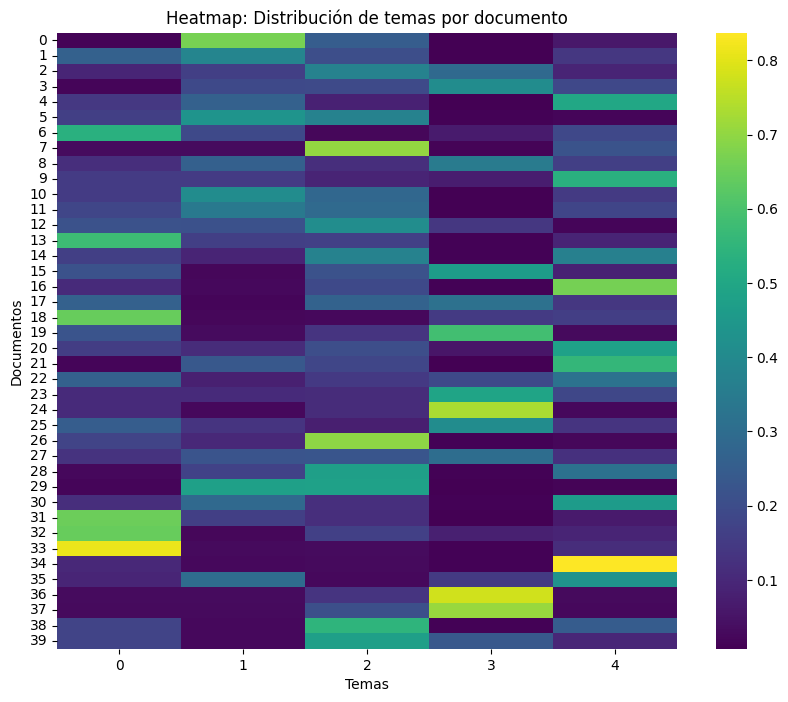

In [47]:
topic_dist_df= pd.DataFrame(topic_dist)
plt.figure(figsize=(10, 8))
sns.heatmap(topic_dist_df, annot=False, cmap='viridis')
plt.title('Heatmap: Distribución de temas por documento')
plt.xlabel('Temas')
plt.ylabel('Documentos')
plt.show()

Se genera una clasificación 'dura' para contrastar con el tema real

In [48]:
df_test['tema_prevalente'] = topic_dist_df.idxmax(axis=1)

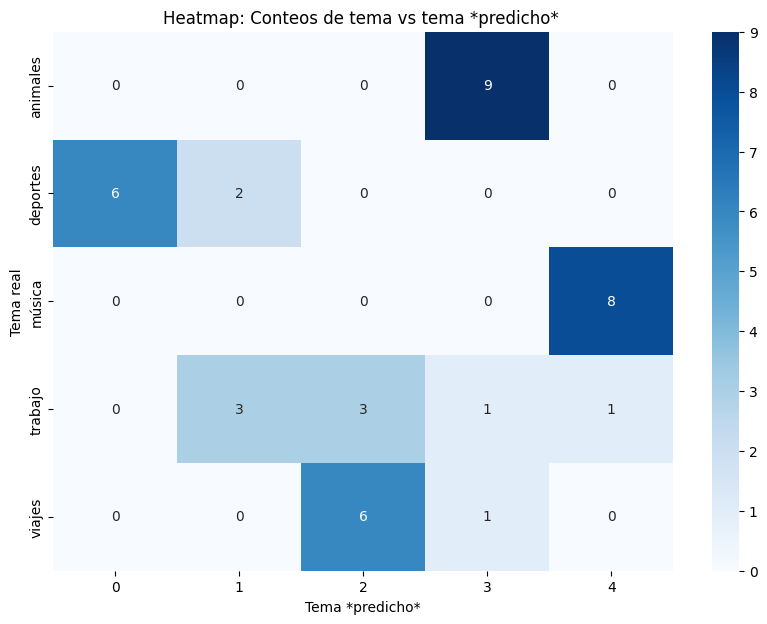

In [49]:
# Tabulación cruzada
crosstab_result = pd.crosstab(df_test['topic'], df_test['tema_prevalente'])

# Heatmap correspondiente
plt.figure(figsize=(10, 7)) # Adjust figure size as needed
sns.heatmap(crosstab_result, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap: Conteos de tema vs tema *predicho* ')
plt.xlabel('Tema *predicho*')
plt.ylabel('Tema real')
plt.show()

## Revisión de variable respuesta por documento

In [68]:
prob_dist = modelo_binario.estimate(documentos_test_tp)
df_test['Prob_Pred']  = [p[0] for p in prob_dist]

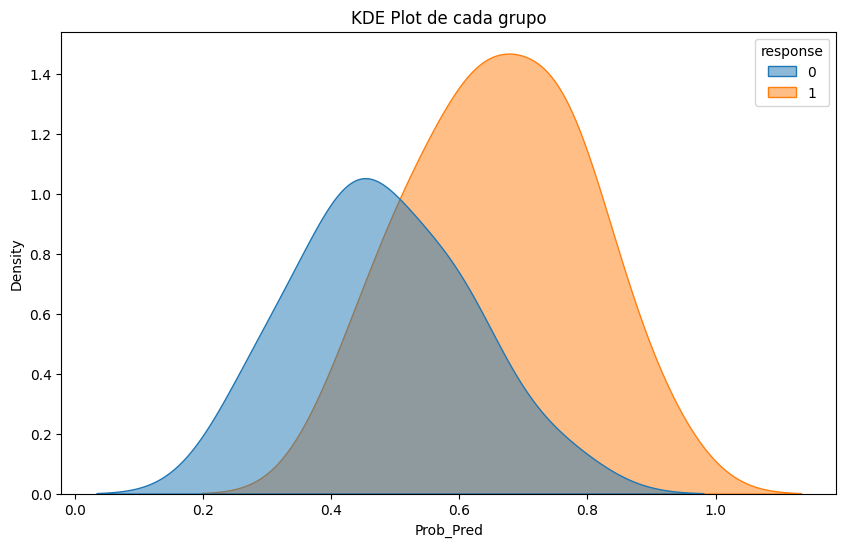

In [71]:
# Plot KDE with hue
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_test, x='Prob_Pred', hue='response', fill=True, alpha=0.5)
plt.title('KDE Plot de cada grupo')
plt.show()